In [21]:
from math import pi
import seaborn as sns
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister
from qiskit import execute, Aer
from qiskit.tools.monitor import job_monitor
import matplotlib.pyplot as plt
from IPython.display import Image

In [31]:
from qiskit import IBMQ
# loads the saved API token, if you haven't saved it run the following line
# IBMQ.save_account('<API token>')
IBMQ.load_accounts()

# True to run the circuit on the simulator, False to run it on the real device
run_simulator = True

## Circuit 1 Visual

<img src="./images/circuit1.png">

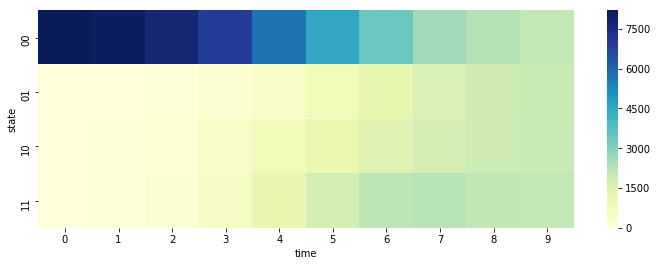

In [34]:
# first circuit

num = 0
# list of linearly increasing time values, starting at 0 - in this case incrementing in steps of 0.02
time_steps = [0]
for i in range(10):
    num += 0.02
    time_steps.append(num)

# list for the number of time steps we want - in this case 0 to 10
time_range = [x for x in range(0,10)]

# possible outcome states for two qubits
states = ['00', '01', '10', '11']

# defining a quantum and corresponding classical registers to create a circuit base
q = QuantumRegister(2)
c = ClassicalRegister(2)
qc = QuantumCircuit(q, c)

# creating empty dataframe to store results
df = pd.DataFrame(columns=['state', 'time', 'value'])

count = 0
# executing the circuit for each time step
for t, t_val in zip(time_steps, time_range):
    # creating the circuit
    # potential
    qc.u1(12*t, q[1])

    # inverse QFT
    qc.barrier(q[0], q[1])
    qc.h(q[0])
    qc.cx(q[1], q[0])
    qc.tdg(q[0])
    qc.cx(q[1], q[0])
    qc.t(q[0])
    qc.t(q[1])
    qc.h(q[1])
    
    # eigenvals and eigenfuncs
    qc.barrier(q[0], q[1])
    qc.u1((-pi**2/4)*t, q[0])
    qc.u1((-pi**2/4)*t,q[1])
    qc.cx(q[1], q[0])
    qc.u1((-pi**2/2)*t, q[0])
    qc.cx(q[1], q[0])
    qc.u1((pi**2/2)*t, q[0])
    qc.u1((pi**2/2)*t, q[1])
    qc.h(q[1])
    
    # QFT
    qc.barrier(q[0], q[1])
    qc.cx(q[1], q[0])
    qc.t(q[0])
    qc.t(q[1])
    qc.cx(q[1], q[0])
    qc.tdg(q[0])
    qc.tdg(q[1])
    qc.h(q[0])
    
    # inverse QFT
    qc.barrier(q[0], q[1])
    qc.h(q[0])
    qc.cx(q[1], q[0])
    qc.tdg(q[0])
    qc.cx(q[1],q[0])
    qc.t(q[0])
    qc.t(q[1])
    qc.h(q[1])

    # eigenvals and eigenfuncs
    qc.barrier(q[0], q[1])
    qc.u1((-pi**2/4)*t, q[0])
    qc.u1((-pi**2/4)*t, q[1])
    qc.cx(q[1], q[0])
    qc.u1((-pi**2/2)*t, q[0])
    qc.cx (q[1], q[0])
    qc.u1((pi**2/2)*t, q[0])
    qc.u1((pi**2/2)*t, q[1])
    qc.h(q[1])

    # QFT
    qc.barrier(q[0], q[1])
    qc.cx(q[1], q[0])
    qc.t(q[0])
    qc.t(q[1])
    qc.cx(q[1], q[0])
    qc.tdg(q[0])
    qc.tdg(q[1])
    qc.h(q[0])
    
    # potential
    qc.barrier(q[0], q[1])
    qc.u1(12*t, q[1])
    
    # measurement
    qc.barrier(q[0], q[1])
    qc.measure(q[0], c[0])
    qc.measure(q[1], c[1])

    
    if run_simulator:
        # running the Aer simulator (fast)
        backend_sim = Aer.get_backend('qasm_simulator')
        job_sim = execute(qc, backend_sim, shots=8192)
        final_result = job_sim.result()
    else:
        # running the ibmqx2 quantum computer (very slow)
        backend_real = IBMQ.get_backend('ibmqx2')
        results = execute(qc, backend_real, shots=8192)
        job_monitor(results)
        final_result = results.result()

    # dictionary of the measured counts, for example:
    # {00: 1024, 01: 450, 10: 5112, 11: 1606}
    dicty = final_result.get_counts(qc)
    
    # adds the results from the dictionary to the dataframe
    for state in states:
        try:
            df.loc[count] = [state, t_val, dicty[state]]
        except KeyError:
            df.loc[count] = [state, t_val, 0]
        count += 1

# creates the heatmap of the results using the dataframe
df = df.pivot("state", "time", "value")
df = df[df.columns].astype(int)
plt.figure(figsize = (12, 4))
ax = sns.heatmap(df, cmap="YlGnBu")

if run_simulator:
    plt.savefig('./images/circ1_heatmap_sim')
else:
    plt.savefig('./images/circ1_heatmap_real')

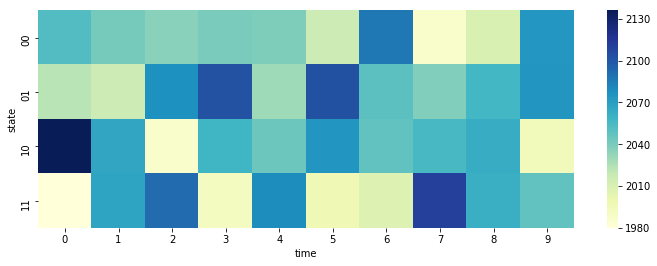

In [35]:
# first circuit with new Quantum Fourier Transform code

num = 0
# list of linearly increasing time values, starting at 0 - in this case incrementing in steps of 0.02
time_steps = [0]
for i in range(10):
    num += 0.02
    time_steps.append(num)

# list for the number of time steps we want - in this case 0 to 10
time_range = [x for x in range(0,10)]

# possible outcome states for two qubits
states = ['00', '01', '10', '11']

# defining a quantum and corresponding classical registers to create a circuit base
q = QuantumRegister(2)
c = ClassicalRegister(2)
qc = QuantumCircuit(q, c)

# creating empty dataframe to store results
df = pd.DataFrame(columns=['state', 'time', 'value'])

count = 0
# executing the circuit for each time step
for t, t_val in zip(time_steps, time_range):
    # creating the circuit
    # potential
    qc.u1(12*t, q[1])

    # inverse QFT
    qc.swap(q[0], q[1])
    qc.h(q[1])
    qc.cu1(-2*pi/2**t, q[0], q[1])
    qc.h(q[0])
    qc.swap(q[0], q[1])
    
    # eigenvals and eigenfuncs
    qc.barrier(q[0], q[1])
    qc.u1((-pi**2/4)*t, q[0])
    qc.u1((-pi**2/4)*t,q[1])
    qc.cx(q[1], q[0])
    qc.u1((-pi**2/2)*t, q[0])
    qc.cx(q[1], q[0])
    qc.u1((pi**2/2)*t, q[0])
    qc.u1((pi**2/2)*t, q[1])
    qc.h(q[1])
    
    # QFT
    qc.swap(q[0], q[1])
    qc.h(q[1])
    qc.cu1(2*pi/2**t, q[0], q[1])
    qc.h(q[0])
    
    # inverse QFT
    qc.swap(q[0], q[1])
    qc.h(q[1])
    qc.cu1(-2*pi/2**t, q[0], q[1])
    qc.h(q[0])
    qc.swap(q[0], q[1])

    # eigenvals and eigenfuncs
    qc.barrier(q[0], q[1])
    qc.u1((-pi**2/4)*t, q[0])
    qc.u1((-pi**2/4)*t, q[1])
    qc.cx(q[1], q[0])
    qc.u1((-pi**2/2)*t, q[0])
    qc.cx (q[1], q[0])
    qc.u1((pi**2/2)*t, q[0])
    qc.u1((pi**2/2)*t, q[1])
    qc.h(q[1])

    # QFT
    qc.swap(q[0], q[1])
    qc.h(q[1])
    qc.cu1(2*pi/2**t, q[0], q[1])
    qc.h(q[0])
    
    # potential
    qc.barrier(q[0], q[1])
    qc.u1(12*t, q[1])
    
    # measurement
    qc.barrier(q[0], q[1])
    qc.measure(q[0], c[0])
    qc.measure(q[1], c[1])

    
    if run_simulator:
        # running the Aer simulator (fast)
        backend_sim = Aer.get_backend('qasm_simulator')
        job_sim = execute(qc, backend_sim, shots=8192)
        final_result = job_sim.result()
    else:
        # running the ibmqx2 quantum computer (very slow)
        backend_real = IBMQ.get_backend('ibmqx2')
        results = execute(qc, backend_real, shots=8192)
        job_monitor(results)
        final_result = results.result()

    # dictionary of the measured counts, for example:
    # {00: 1024, 01: 450, 10: 5112, 11: 1606}
    dicty = final_result.get_counts(qc)
    
    # adds the results from the dictionary to the dataframe
    for state in states:
        try:
            df.loc[count] = [state, t_val, dicty[state]]
        except KeyError:
            df.loc[count] = [state, t_val, 0]
        count += 1

# creates the heatmap of the results using the dataframe
df = df.pivot("state", "time", "value")
df = df[df.columns].astype(int)
plt.figure(figsize = (12, 4))
ax = sns.heatmap(df, cmap="YlGnBu")

if run_simulator:
    plt.savefig('./images/circ1_heatmap_sim_qftnew')
else:
    plt.savefig('./images/circ1_heatmap_qftnew')

## Circuit 2 Visual

<img src="./images/circuit2.png">

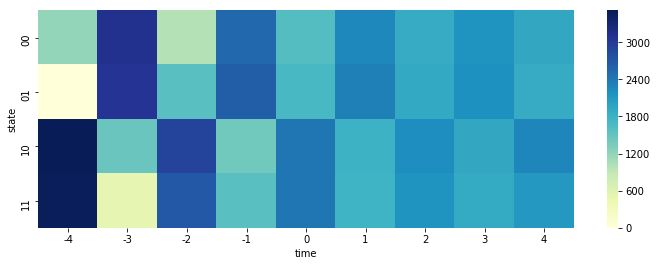

In [4]:
# second circuit
# if this section errors when running, restart Jupyter

# time starts at negative value
num = -0.08
# list of linearly increasing time values, starting at -0.08 - in this case incrementing in steps of 0.02
time_steps = [0]
for i in range(-4, 5):
    num += 0.02
    time_steps.append(num)

# list for the number of time steps we want - in this case 0 to 10
time_range = [x for x in range(-4, 5)]

# possible outcome states for two qubits
states = ['00', '01', '10', '11']

# defining a quantum and corresponding classical registers to create a circuit base
q = QuantumRegister(2)
c = ClassicalRegister(2)
qc = QuantumCircuit(q, c)

# creating empty dataframe to store results
df = pd.DataFrame(columns=['state', 'time', 'value'])

count = 0
# executing the circuit for each time step
for t, t_val in zip(time_steps, time_range):
    # creating the circuit
    qc.u1(12*t, q[1])
    
    qc.barrier(q[0], q[1])
    qc.h(q[0])
    qc.cx(q[1], q[0])
    qc.tdg(q[0])
    qc.cx(q[1], q[0])
    qc.t(q[0])
    qc.t(q[1])
    qc.h(q[1])
    
    qc.barrier(q[0], q[1])
    qc.x(q[0])
    qc.cx(q[0], q[1])
    qc.u1((pi**2/4)*t, q[0])
    qc.x(q[0])
    qc.cx(q[0], q[1])
    qc.cx(q[0], q[1])
    qc.u3(pi, pi**2*t,(pi**2/4)*t, q[0])
    qc.x(q[0])
    qc.cx(q[0], q[1])
    
    qc.barrier(q[0], q[1])
    qc.cx(q[1], q[0])
    qc.t(q[0])
    qc.t(q[1])
    qc.cx(q[1], q[0])
    qc.tdg(q[0])
    qc.tdg(q[1])
    qc.h(q[0])
    
    qc.barrier(q[0], q[1])
    qc.h(q[0])
    qc.cx(q[1], q[0])
    qc.tdg(q[0])
    qc.cx(q[1], q[0])
    qc.t(q[0])
    qc.t(q[1])
    qc.h(q[1])
    
    qc.barrier(q[0], q[1])
    qc.x(q[0])
    qc.cx(q[0], q[1])
    qc.u1((pi**2/4)*t, q[0])
    qc.x(q[0])
    qc.cx(q[0], q[1])
    qc.cx(q[0], q[1])
    qc.u3(pi, pi**2*t,(pi**2/4)*t, q[0])
    qc.x(q[0])
    qc.cx(q[0], q[1])
    
    qc.barrier(q[0], q[1])
    qc.cx(q[1], q[0])
    qc.t(q[0])
    qc.t(q[1])
    qc.cx(q[1],q[0])
    qc.tdg(q[0])
    qc.tdg(q[1])
    qc.h(q[0])
    
    qc.barrier(q[0], q[1])
    qc.u1(12*t, q[1])
    
    qc.barrier(q[0], q[1])
    qc.measure(q[0], c[0])
    qc.measure(q[1], c[1])

    if run_simulator:
        # running the Aer simulator (fast)
        backend_sim = Aer.get_backend('qasm_simulator')
        job_sim = execute(qc, backend_sim, shots=8192)
        final_result = job_sim.result()
    else:
        # running the ibmqx2 quantum computer (very slow)
        backend_real = IBMQ.get_backend('ibmqx2')
        results = execute(qc, backend_real, shots=8192)
        job_monitor(job_exp)
        final_result = results.result()

    # dictionary of the measured counts, for example:
    # {00: 1024, 01: 450, 10: 5112, 11: 1606}
    dicty = final_result.get_counts(qc)
    
    # adds the results from the dictionary to the dataframe
    for state in states:
        try:
            df.loc[count] = [state, t_val, dicty[state]]
        except KeyError:
            df.loc[count] = [state, t_val, 0]
        count += 1
            
# creates the heatmap of the results using the dataframe
df = df.pivot("state", "time", "value")
df = df[df.columns].astype(int)
plt.figure(figsize = (12, 4))
ax = sns.heatmap(df, cmap="YlGnBu")

if run_simulator:
    plt.savefig('./images/circ2_heatmap_sim')
else:
    plt.savefig('./images/circ2_heatmap_real')